https://www.kaggle.com/c/spooky-author-identification/data    
https://www.kaggle.com/enerrio/scary-nlp-with-spacy-and-keras/notebook

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
from collections import Counter
from time import time
from sklearn.preprocessing import label_binarize
import spacy

In [2]:
# Load training and testing text
train = pd.read_csv('train.csv', skiprows=1, names=['ID', 'Text', 'Author']).set_index('ID')
test = pd.read_csv('test.csv', skiprows=1, names=['ID', 'Text']).set_index('ID')

# Delete the word 'id' from the ID columns
train.index = [id[2:] for id in train.index]
test.index = [id[2:] for id in test.index]

In [3]:
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Training Data Shape: (19579, 2)
Testing Data Shape: (8392, 1)


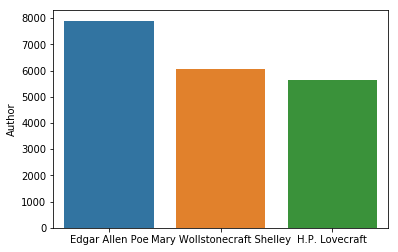

In [4]:
# Barplot of occurances of each author in the training dataset
sns.barplot(x=['Edgar Allen Poe', 'Mary Wollstonecraft Shelley', 'H.P. Lovecraft'], y=train['Author'].value_counts())
plt.show()

In [5]:
# Load spacy's predefined word vectors.
nlp = spacy.load('en_core_web_sm')

### Clean text before feeding it to spaCy

In [19]:
# Let's use the spacy default list of stopwords.
stopwords=nlp.Defaults.stop_words
len(stopwords)

305

In [20]:
# and also the predefined list of punctuation.
punctuations = string.punctuation
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Here's an example of what this looks like for one text:

In [28]:
doc=train['Text'][0]
doc

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [30]:
doc = nlp(doc, disable=['parser', 'ner'])
doc

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.

In [34]:
tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
tokens[:6]

['this', 'process', ',', 'however', ',', 'afford']

In [35]:
tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
tokens[:5]

['process', 'afford', 'mean', 'ascertain', 'dimension']

In [36]:
tokens = ' '.join(tokens)
tokens

'process afford mean ascertain dimension dungeon circuit return point set aware fact perfectly uniform wall'

In [39]:
texts=[]
texts.append(tokens)
texts

['process afford mean ascertain dimension dungeon circuit return point set aware fact perfectly uniform wall']

In [40]:
train_cleaned=pd.Series(texts)
train_cleaned

0    process afford mean ascertain dimension dungeo...
dtype: object

#### This is where we apply the magic.
We want to extract the doc vectors.

In [49]:
# What does nlp.pipe mean?
nlp.pipe(train_cleaned, batch_size=500)

<generator object Language.pipe at 0x000001C18277BCF0>

The .pipe() method accepts an iterator (above, texts), and produces an iterator. Internally, a buffer is accumulated (given by the batch_size argument, and multiple threads are allowed to work on the batch simultaneously. Once the batch is complete, the processed documents are yielded from the iterator.   
https://spacy.io/usage/processing-pipelines#_title   

With a small dataset like ours, the `pipe()` method may actually not improve speed. For a discussion, see here: https://github.com/explosion/spaCy/issues/2457

In [52]:
for doc in nlp.pipe(train_cleaned, batch_size=500):
    print(doc)

process afford mean ascertain dimension dungeon circuit return point set aware fact perfectly uniform wall


In [55]:
for doc in nlp.pipe(train_cleaned, batch_size=500):
    print(doc.vector)
    print(len(doc.vector))

[ 1.0476121e-01  2.3563533e-01  1.1642744e-01 -5.1357806e-01
 -7.0594954e-01  7.1790761e-01 -3.6895845e+00  5.3046930e-01
  7.9044694e-01  1.0269741e+00  2.4017451e+00 -2.0028777e+00
  4.7862008e-01  7.9244715e-01 -2.4165776e+00 -2.2602086e-01
 -2.8694737e+00 -1.4366758e+00 -1.1208347e+00  7.4641931e-01
  2.0910411e+00  3.4391001e-01  4.2376930e-01  5.1758146e-01
 -3.8994586e-01 -2.0091887e+00  2.5123468e-01  2.2551560e+00
 -4.1971320e-01 -6.4928018e-02 -9.9156898e-01  2.9985988e-01
  6.8709689e-01 -3.3587897e-01 -1.2926331e+00 -9.9748838e-01
  1.9331013e+00 -5.0762230e-01  1.3239610e+00  3.6108080e-01
 -1.3520045e+00 -4.8931080e-01  1.3091699e+00  1.1037768e+00
 -1.9580992e-01  7.6484972e-01 -1.1280066e+00 -1.2946528e+00
  2.0583148e+00 -6.2141681e-01  1.5940531e+00 -1.1652075e+00
 -8.8208187e-01  3.2341394e+00  5.6179976e-01 -8.9787710e-01
  3.2376616e+00  2.3223841e+00 -1.1888937e+00 -8.2781399e-03
 -1.3797412e+00  8.6898655e-01 -1.6932533e+00  1.1103157e+00
  1.5140477e+00 -5.96196

In [44]:
train_vec = []
for doc in nlp.pipe(train_cleaned, batch_size=500):
    train_vec.append(doc.vector)
train_vec[0][:10]

array([ 0.10476121,  0.23563533,  0.11642744, -0.51357806, -0.70594954,
        0.7179076 , -3.6895845 ,  0.5304693 ,  0.79044694,  1.0269741 ],
      dtype=float32)

In [53]:
# why is it length 128? and is this the same for every text?
print(len(train_vec))
print(len(train_vec[0]))
print(len(texts))
print(len(tokens))
print(len(train_cleaned))

1
128
1
106
1


#### Apparently 128 is an important number for spacy vectors.
spaCy comes with built-in support for loading GloVe vectors from a directory. The Vectors.from_glove method assumes a binary format, the vocab provided in a vocab.txt, and the naming scheme of vectors.There are 2 pretrained glove vectors to choose from, of dimensions 128 and 300.
* vectors.128.f.bin	128	float32
* vectors.300.d.bin	300	float64 (double)   
https://spacy.io/usage/vectors-similarity

See also this note from Jeff Nicolech:
When you disable 'parser' and 'ner', you are left with "quasi" word vectors (but not really) with a shape of (128,). Thus, the remaining code needs to be adapted for inputs of dimension 128. Alternately, you could download pre-trained GloVe vectors which would have the same shape (300,) as the Word2Vec vectors.
https://www.kaggle.com/enerrio/scary-nlp-with-spacy-and-keras

### Now, as a pipeline.

In [7]:
# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [14]:
# Cleanup text and make sure it retains original shape
print('Original training data shape: ', train['Text'].shape)
train_cleaned = cleanup_text(train['Text'], logging=True)
print('Cleaned up training data shape: ', train_cleaned.shape)
assert train['Text'].shape==train_cleaned.shape

Original training data shape:  (19579,)
Processed 1000 out of 19579 documents.
Processed 2000 out of 19579 documents.
Processed 3000 out of 19579 documents.
Processed 4000 out of 19579 documents.
Processed 5000 out of 19579 documents.
Processed 6000 out of 19579 documents.
Processed 7000 out of 19579 documents.
Processed 8000 out of 19579 documents.
Processed 9000 out of 19579 documents.
Processed 10000 out of 19579 documents.
Processed 11000 out of 19579 documents.
Processed 12000 out of 19579 documents.
Processed 13000 out of 19579 documents.
Processed 14000 out of 19579 documents.
Processed 15000 out of 19579 documents.
Processed 16000 out of 19579 documents.
Processed 17000 out of 19579 documents.
Processed 18000 out of 19579 documents.
Processed 19000 out of 19579 documents.
Cleaned up training data shape:  (19579,)


In [15]:
# Parse documents and print some info
print('Parsing documents...')

start = time()

train_vec = []
for doc in nlp.pipe(train_cleaned, batch_size=500):
    if doc.has_vector:
        train_vec.append(doc.vector)
    # If doc doesn't have a vector, then fill it with zeros.
    else:
        train_vec.append(np.zeros((128,), dtype="float32"))
        
train_vec = np.array(train_vec)

end = time()
print('Total time passed parsing documents: {} seconds'.format(end - start))
print('Total number of documents parsed: {}'.format(len(train_vec)))
print('Number of words in first document: ', len(train['Text'][0]))
print('Number of words in second document: ', len(train['Text'][1]))
print('Size of vector embeddings: ', train_vec.shape[1])
print('Shape of vectors embeddings matrix: ', train_vec.shape)

Parsing documents...
Total time passed parsing documents: 101.89002442359924 seconds
Total number of documents parsed: 19579
Number of words in first document:  231
Number of words in second document:  71
Size of vector embeddings:  128
Shape of vectors embeddings matrix:  (19579, 128)


In [16]:
len(train_vec[0])

128

In [17]:
## Pickle the results for use in next step.
import pickle
file = open('spooky_train_vec.pkl', 'wb')
pickle.dump(train_vec, file)
file.close()

#### Nice to have: Plot most frequent words in each corpus

In [ ]:
def cleaner_upper(text):
    cleany = cleanup_text(text)
    cleany = ' '.join(cleany).split()
    # 's appears a lot in the text, so we get rid of it since it's not a word
    cleany = [word for word in cleany if word != '\'s']
    return cleany

In [ ]:
# Grab all text associated with Edgar Allen Poe
eap_text = [text for text in train[train['Author'] == 'EAP']['Text']]

# Grab all text associated with H.P. Lovecraft
hpl_text = [text for text in train[train['Author'] == 'HPL']['Text']]

# Grab all text associated with Mary Wollstonecraft Shelley
mws_text = [text for text in train[train['Author'] == 'MWS']['Text']]

eap_clean=cleaner_upper(eap_text)
hpl_clean=cleaner_upper(hpl_text)
mws_clean=cleaner_upper(mws_text)

In [ ]:
# Count all unique words
eap_counts = Counter(eap_clean)
hpl_counts = Counter(hpl_clean)
mws_counts = Counter(mws_clean)

Text(0.5, 1.0, 'Most Common Words used by Edgar Allen Poe')

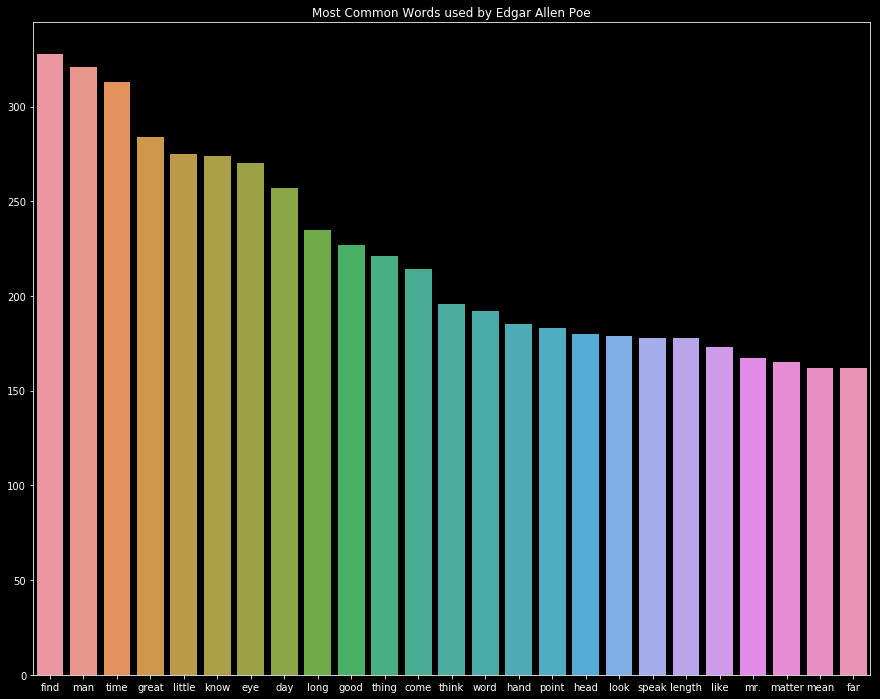

In [18]:
# Plot top 25 most frequently occuring words for Edgar Allen Poe
eap_common_words = [word[0] for word in eap_counts.most_common(25)]
eap_common_counts = [word[1] for word in eap_counts.most_common(25)]

# Use spooky background
plt.style.use('dark_background')
plt.figure(figsize=(15, 12))

sns.barplot(x=eap_common_words, y=eap_common_counts)
plt.title('Most Common Words used by Edgar Allen Poe')
# plt.show()

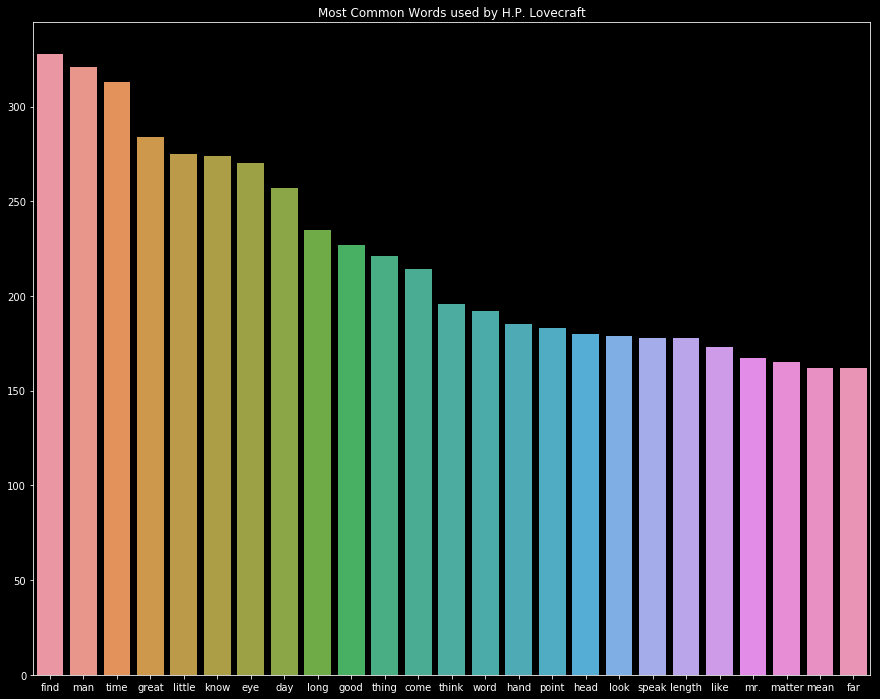

In [ ]:
# Plot top 25 most frequently occuring words for H.P. Lovecraft
hpl_common_words = [word[0] for word in hpl_counts.most_common(25)]
hpl_common_counts = [word[1] for word in hpl_counts.most_common(25)]

plt.figure(figsize=(15, 12))
sns.barplot(x=hpl_common_words, y=hpl_common_counts)
plt.title('Most Common Words used by H.P. Lovecraft')
# plt.show()

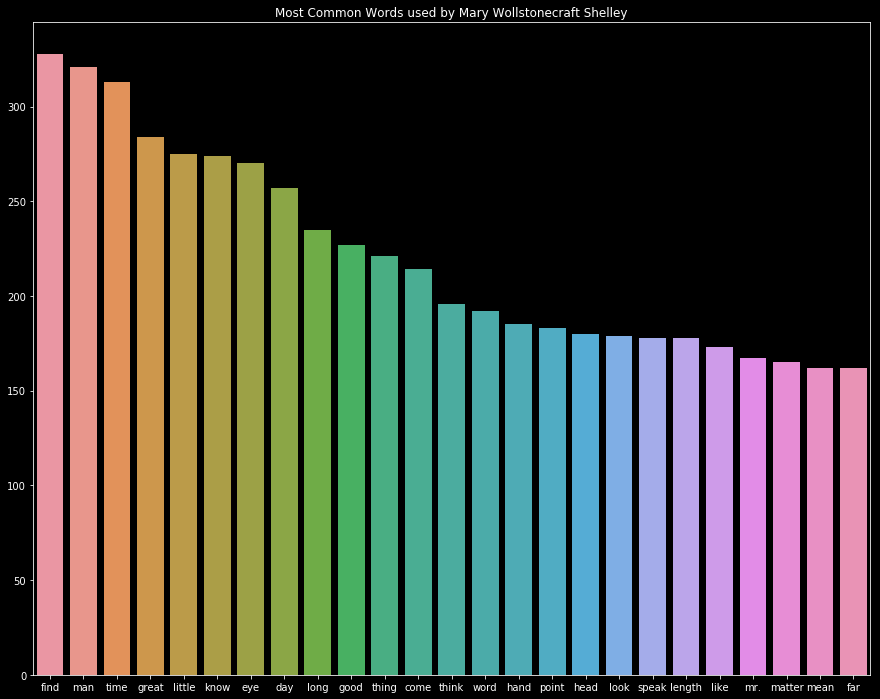

In [ ]:
# Plot top 25 most frequently occuring words for Mary Wollstonecraft Shelley
mws_common_words = [word[0] for word in mws_counts.most_common(25)]
mws_common_counts = [word[1] for word in mws_counts.most_common(25)]

plt.figure(figsize=(15, 12))
sns.barplot(x=mws_common_words, y=mws_common_counts)
plt.title('Most Common Words used by Mary Wollstonecraft Shelley')
# plt.show()